In [1]:
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"
thrb = "MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE"
actb = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF"

In [2]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids

protein = pr39

enzymes1 = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)

enzymes2 = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "K+R protease"),
    ],
    [1],
    [1],
)


enzymes3 = enzyme_set(
    [
        enzyme({"V": 0.3, "I": 0.3, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)



In [3]:
from disassembly.simulate_proteolysis import ProteolysisSimulator

results = {}
test_names = ["simple", "medium", "complex", "random"]
iterations = 2
simulated_peptidomes = {}
simulated_graphs = {}
generated_graphs = {}

# Simulating peptidomes
ps = ProteolysisSimulator()
for test_name, enzymes in zip(test_names, [enzymes1, enzymes2, enzymes3, random]):
    simulated_peptidomes[test_name] = {}
    simulated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(f"Running {test_name} {iteration}")
        simulated_peptidome, simulated_graph = ps.simulate_proteolysis(
            protein,
            enzymes,
            n_start=3,
            n_generate=500,
            endo_or_exo_probability=[0.9, 0.1],
            length_params="vivo"
        )
        simulated_peptidomes[test_name][iteration] = simulated_peptidome
        simulated_graphs[test_name][iteration] = simulated_graph


Running simple 0
 45 / 500 (48)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:229: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values())


 499 / 500 (589)
26 unique peptides. 503 total
Running simple 1
 499 / 500 (588)
28 unique peptides. 503 total
Running medium 0
 499 / 500 (586)
120 unique peptides. 503 total
Running medium 1
 499 / 500 (546)
107 unique peptides. 503 total
Running complex 0
 499 / 500 (537)
116 unique peptides. 503 total
Running complex 1
 499 / 500 (540)
122 unique peptides. 503 total
Running random 0
 499 / 500 (515)
407 unique peptides. 503 total
Running random 1
 498 / 500 (511)
434 unique peptides. 503 total


0.6618416251064347

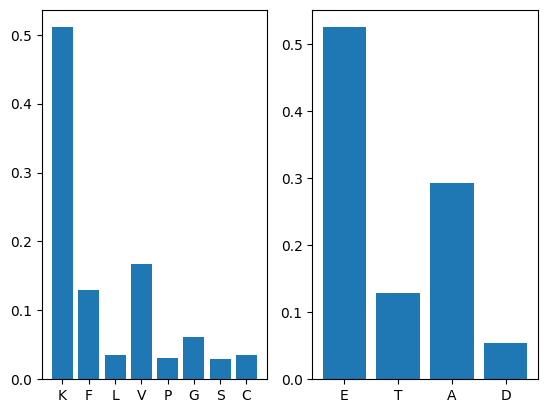

In [4]:
from disassembly.cut_site import get_p1
import matplotlib.pyplot as plt

p1_endo, p1_exo,  n_endo, n_exo = get_p1(simulated_graphs["simple"][0], 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

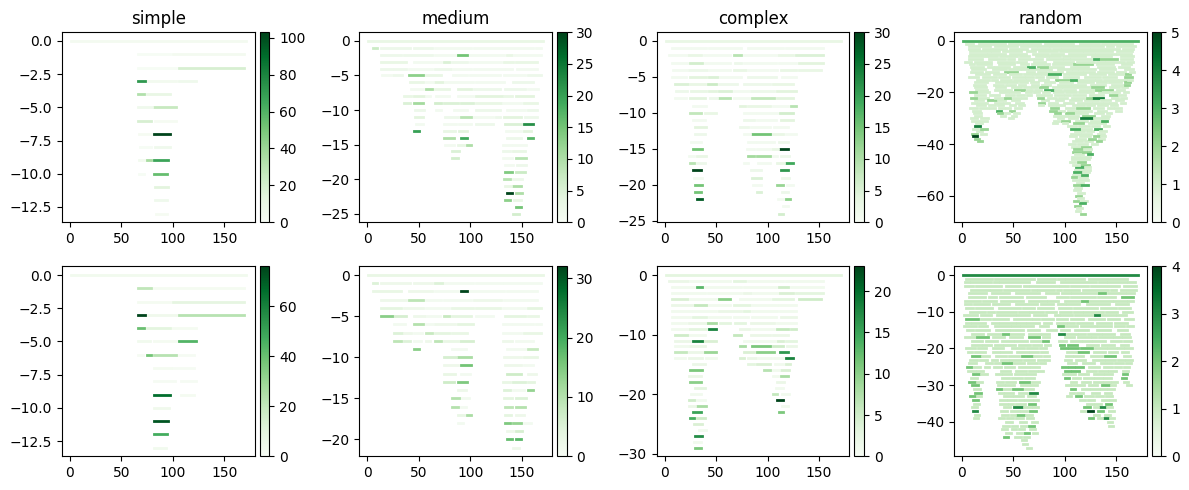

In [5]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    iterations, len(test_names), figsize=(len(test_names) * 3, iterations * 2.5)
)
for iteration in range(iterations):
    for test_name in test_names:
        ax = axs[iteration, test_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()

# Regex

In [6]:
from disassembly.simulate_proteolysis_regex import Enzyme
trypsin_regex = Enzyme("trypsin", {"..[RK](?!P).." : 1})
random_regex = Enzyme("random", {"......": 1})
chymotrp_regex = Enzyme("chymotrypsin", {"..[FYW](?!P).." : 1})

from disassembly.simulate_proteolysis_regex import ProteolysisSimulator

results = {}
test_names = ["trypsin", "random", "chymotrypsin"] #["simple", "medium", "complex", "random"]
iterations = 2
simulated_peptidomes = {}
simulated_graphs = {}
generated_graphs = {}

# Simulating peptidomes
ps = ProteolysisSimulator()
for test_name, enzymes in zip(test_names, [trypsin_regex, random_regex, chymotrp_regex]):
    simulated_peptidomes[test_name] = {}
    simulated_graphs[test_name] = {}
    for iteration in range(iterations):
        print(f"Running {test_name} {iteration}")
        simulated_peptidome, simulated_graph = ps.simulate_proteolysis(
            protein,
            enzymes,
            n_start=3,
            n_generate=200,
            endo_or_exo_probability=[0.9, 0.1],
            length_params="vivo",
            noise=1e-10
        )
        simulated_peptidomes[test_name][iteration] = simulated_peptidome
        simulated_graphs[test_name][iteration] = simulated_graph


Running trypsin 0
 35 / 200 (42)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis_regex.py:28: RuntimeWarning: divide by zero encountered in divide
  cleavage_probabilities = cleavage_probabilities / sum(cleavage_probabilities)
/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis_regex.py:28: RuntimeWarning: invalid value encountered in divide
  cleavage_probabilities = cleavage_probabilities / sum(cleavage_probabilities)


 199 / 200 (212)
56 unique peptides. 203 total
Running trypsin 1
 199 / 200 (211)
59 unique peptides. 203 total
Running random 0
 199 / 200 (233)
136 unique peptides. 205 total
Running random 1
 198 / 200 (277)
141 unique peptides. 203 total
Running chymotrypsin 0
 199 / 200 (206)
28 unique peptides. 203 total
Running chymotrypsin 1
 199 / 200 (210)
30 unique peptides. 203 total


0.5866809151406227

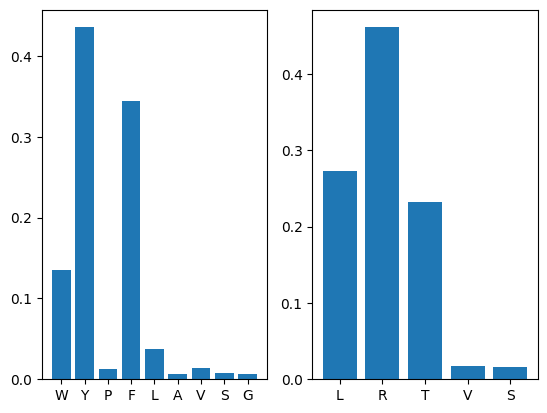

In [7]:
from disassembly.cut_site import get_p1
import matplotlib.pyplot as plt

p1_endo, p1_exo,  n_endo, n_exo = get_p1(simulated_graphs["chymotrypsin"][0], 10000)
fig, axs = plt.subplots(1,2)
axs[0].bar(p1_endo.keys(), height=p1_endo.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
n_endo / (n_exo + n_endo)

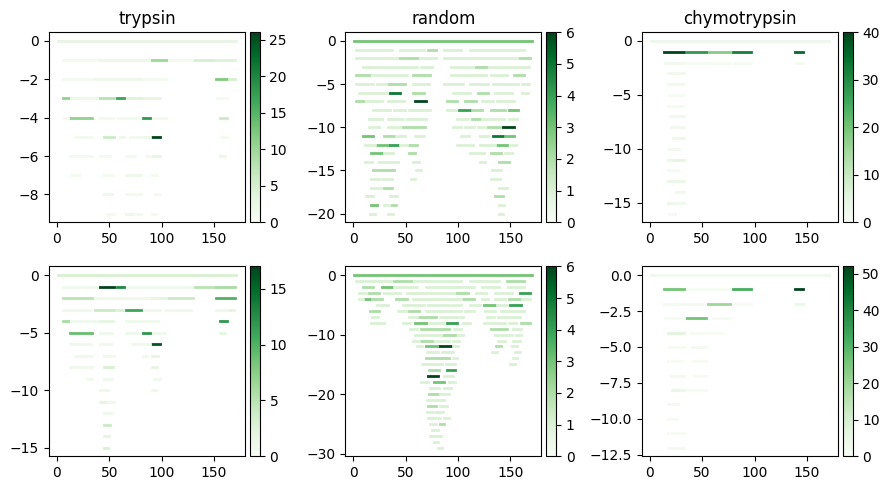

In [8]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    iterations, len(test_names), figsize=(len(test_names) * 3, iterations * 2.5)
)
for iteration in range(iterations):
    for test_name in test_names:
        ax = axs[iteration, test_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()